# ALS Fitting Code Example: H<sub>2</sub>O<sub>2</sub> Photolysis

Whenever a setup cell is modified, it must be rerun for the change to be reflected in calls to model functions.

Can use for non-ALS data by setting apply_IRF and apply_PG flags to False, so long as data is all data points are an integer multiple of 0.02 ms.

Like most nonlinear fits, the fit results can be highly sensitive to the choice of initial guess, particularly as the number of fitted parameters increases.  Some tips if your results seem sensetive to initial guess:

(1) Use plot fit code block to get your initial guess close to something reasonable.  If you're unable to get something visually close by adjusting the initial guess, then it's a good indication that your model is not describing the phenomenon you are trying to capture, some fixed parameters are innacurate, etc.  I've found that the results are much more sensitive to initial guess when the fit quality is visually poor.

(2) Consider the error bars on the parameters - are the results from different when initial guesses are varied?  Or are the results within error?  Bootstrap will typically give you a MUCH more accurate sense of your error, which is typically larger than the error outputted solely from the fit.

(3) Also consider covariance.  If one fitted parameter changed substantailly, did any parameters to which it is highly correlated also change?  This suggests your model / data cannot independently determine these two parameters, and they are only varying within error (see above point).

(4) Try decreasing ftol/xol or increasing maxfev (whichever is causing the solver to terminate) - in practice, this hasn't made much of a difference.

err_weight = False tends to give better fits when a species has poor signal to noise (like OH)

# Setup: Modules

Be sure to run this code block first.  Imports all of the modules necessary for the rest of the notebook.  Note that the ALS module also has matplotlib and scipy as dependencies, even though we do not need to import them within this notebook.

This example notebook was developed and tested using the following packages/versions.  Other versions may also work.    
 - python (3.6.1)
 - numpy (1.12.1)
 - pandas (0.20.1)
 - scipy (0.19.0)
 - matplotlib (2.2.2)
 - ipython (5.3.0)
 - ALS (1.0.0)

In [2]:
import numpy as np
import pandas as pd
from IPython.display import display
import ALS

# Setup: User Model

#### Step 1: Define the user model. 

This is the step that requires the most coding on behalf of the user.  I prefer to code the user model in a separate text editor (Sublime Text), save it as a module, and then import it.  The ex_model_1.py file contains the example model_H2O2_depletion with comments providing an explanation how to structure the user model.  It is recommended to follow the template provided there, although any function that has the correct arguments / returns (see below) will work.

*function* **user_model**(*t, model_params*)

**Parameters:**

>**t : *ndarray***
>>Time axis (ms) over which to integrate the model.

>**model_params : *dict***
>>Keys (strings) are the names of the parameters used by the model; values (floats) are the parameter values.  Any parameters that will be fit or included in a monte carlo simulation of systematic error should be included.  Only one parameter is required: 'X0' is the key and the initial radical concentration is its value.

**Returns:** It is only required to return species for which there is observable data to fit; returning other species from the model is optional, but could be useful when plotting model output.  The keys of *m* and *c* must be the same.

>**m : *dict***
>>Keys (strings) are the names of species returned by the model; values (floats) are their masses (amu).

>**c : *dict***
>>Keys (strings) are the names of species returned by the model; values (ndarray) are concentrations (molc/cm<sup>3</sup>) corresponding to times in *t*.  

In [3]:
from ex_model_1 import model_H2O2_depletion

#### Step 2: Instantiate the KineticModel object.

<style>p.param { margin-left: 10px; !important }</style>

*class* **ALS.KineticModel**(*user_model, err_weight=True, fit_pre_photo=False, apply_IRF=True, apply_PG=True, t_PG=1.0*)

**Parameters:**

>**user_model : *callable***
>>The user model function defined in Step 1.

>**err_weight : *bool, optional***
>> If True, the contribution of each data point to the fit cost function is weighted by its uncertainty.

>**fit_pre_photo : *bool, optional***
>> If True, the fit cost function is calculated across all *t*.  If False, the fit cost function is calculated only using data for which *t* ≥ *t0*.  If *t0* is being fit, then this MUST be set to True.  While every model is different, this should generally be left at the default value of False unless *t0* is being fit.

>**apply_IRF : *bool, optional***
>> If True, then the output of the model integration will be convolved with the IRF.

>**apply_PG : *bool, optional***
>> If True, then the model will be integrated in steps (set by *t_PG*) with a linearly changing initial radical concentration.

>**t_PG : *float, optional***
>>The step size (in ms) used for updating the radical concentration and implementing the photolysis gradient.  Required to be an integer multiple of 0.02 ms; recommended to be an integer multiple of *tbin* \* 0.02 ms.  Smaller values will give more accurate results but increase computation time.  The default value of 1 ms is often a good tradeoff.  Ignored if *apply_PG* is False.

In [4]:
model = ALS.KineticModel(model_H2O2_depletion, err_weight=False)

# Setup: Species Data

Step 1:

Should this be changed to load the t-axis from the data file?  I prefer no.

In [5]:
tbin = 10                    # tbin used when data was loaded from Igor
t_start = -20                # Trim the data to t_start inclusive (ms)
t_end = 59.8                 # Trim the data to t_end inclusive (ms)
fn_val = 'ex_data_val_1.csv' # Filename for the data values
fn_err = 'ex_data_err_1.csv' # Filename for the error in the data

dt = 0.02                    # Fundaemental kinetic time step (ms)
t = np.linspace(-20,130,num=int(150/(dt*tbin)),endpoint=False)

df_val = pd.read_csv(fn_val)
df_err = pd.read_csv(fn_err)

idx_start = np.abs(t-t_start).argmin()
idx_end = np.abs(t-t_end).argmin()
drop_indices = np.concatenate((np.arange(idx_start),np.arange(idx_end+1,t.size)))

t = t[idx_start:idx_end+1]
df_val = df_val.drop(drop_indices, axis=0).reset_index(drop=True)
df_err = df_err.drop(drop_indices, axis=0).reset_index(drop=True)

Step 2:

In [6]:
data = {}
data['H2O2'] = {'val':df_val['H2O2'].values, 'err':df_err['H2O2'].values, 'fit':True, 'weight':1}
data['HO2']  = {'val':df_val['HO2'].values,  'err':df_err['HO2'].values,  'fit':True, 'weight':1}
data['OH']   = {'val':df_val['OH'].values,   'err':df_err['OH'].values,   'fit':True, 'weight':1}
data = pd.DataFrame.from_dict(data, orient='index')

display(data)

,val,err,fit,weight
H2O2,"[6135.0, 6162.0, 6025.0, 6005.0, 6027.0, 6101....","[78.326, 78.498, 77.621, 77.492, 77.634, 78.10...",True,1
HO2,"[-3.15, -4.15, -3.15, -4.15, 5.85, 6.85, -1.15...","[5.0, 4.899, 5.0, 4.899, 5.831, 5.9161, 5.1962...",True,1
OH,"[-0.82, 0.18, 0.18, -0.82, -0.82, -0.82, 1.18,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.4142, 1.0, 1....",True,1


# Setup: Model and ALS Parameters

In [7]:
c_H2O2_0 = 5.25e14
idx_zero = np.abs(t-(-1.68)).argmin()
S_H2O2 = df_val.iloc[:idx_zero,df_val.columns.get_loc('H2O2')].mean() / c_H2O2_0

model_params = {}
model_params['X0'] =         {'val':4.2e12,     'err':0,  'fit':True}
model_params['k_OH_wall'] =  {'val':25,        'err':0, 'fit':True}
model_params['k_HO2_wall'] = {'val':6,        'err':0, 'fit':True}
model_params['T'] =          {'val':298.,       'err':0,  'fit':False}
model_params['P'] =          {'val':30.,        'err':0,  'fit':False}
model_params['c_H2O2_0'] =   {'val':c_H2O2_0,   'err':0,  'fit':False}
model_params = pd.DataFrame.from_dict(model_params, orient='index')

print('Inputted Model Params:')
display(model_params)

ALS_params = {}
ALS_params['S_H2O2'] =  {'val':S_H2O2,    'err':0, 'fit':False}
ALS_params['S_OH'] =    {'val':3.6e-11,     'err':0, 'fit':True}
ALS_params['S_HO2'] =   {'val':2.6e-10,     'err':0, 'fit':True}
ALS_params['A'] =       {'val':-0.022,  'err':0, 'fit':False}
ALS_params['B'] =       {'val':4.85e-3,   'err':0, 'fit':False}
ALS_params['t0'] =      {'val':-0.5,     'err':0, 'fit':False}
ALS_params = pd.DataFrame.from_dict(ALS_params, orient='index')

print('Inputted ALS Params:')
display(ALS_params)

Inputted Model Params:


,val,err,fit
P,3.000000e+01,0,False
T,2.980000e+02,0,False
X0,4.200000e+12,0,True
c_H2O2_0,5.250000e+14,0,False
k_HO2_wall,6.000000e+00,0,True
k_OH_wall,2.500000e+01,0,True


Inputted ALS Params:


,val,err,fit
A,-2.200000e-02,0,False
B,4.850000e-03,0,False
S_H2O2,1.149961e-11,0,False
S_HO2,2.600000e-10,0,True
S_OH,3.600000e-11,0,True
t0,-5.000000e-01,0,False


# Plot the model in concentration units

Plots all species returned by the user model regardless of the fit True/False in data

<IPython.core.display.Javascript object>


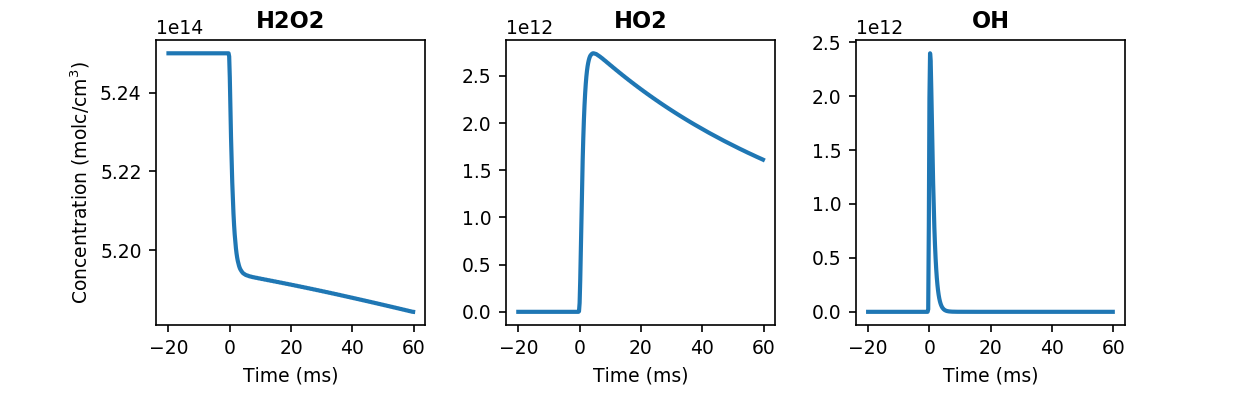

In [8]:
% matplotlib notebook

model.plot_model(t_start, t_end, tbin, model_params, ALS_params, save_fn='ex_init_model_conc_1.csv')

# Plot the data overlaid with the scaled model

Use cases:
1. plotting a previous fit without having to rerun the fit code\n
2. playing around with initial guesses before performing a fit\n
3. saving optimized model * scale factor for each species in order to plot elsewere

<IPython.core.display.Javascript object>


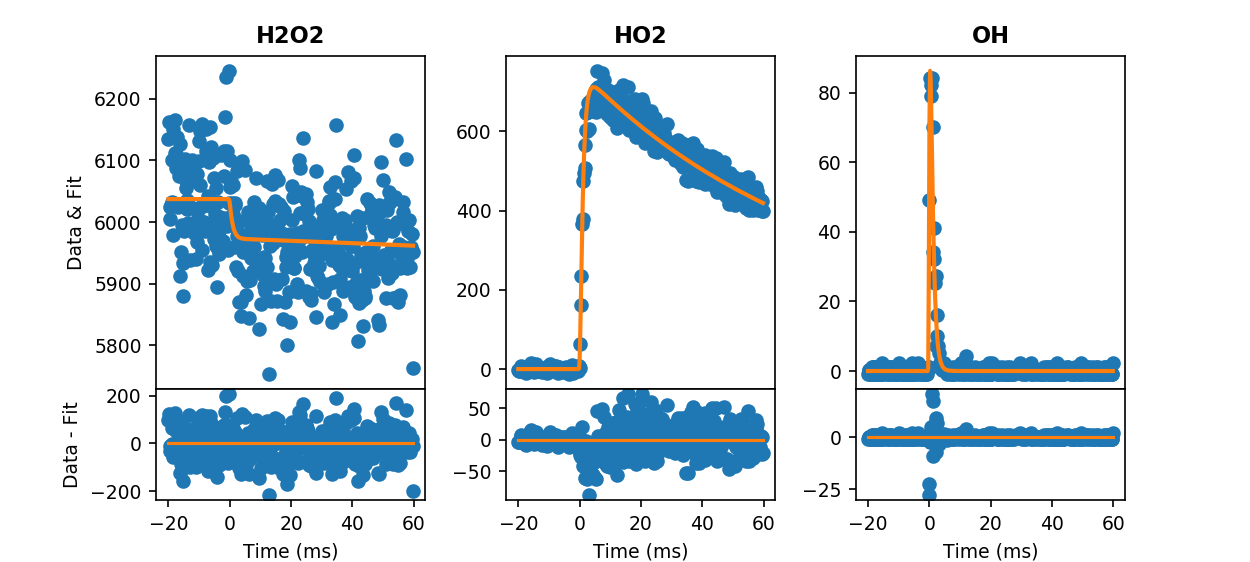


Cost Function Value = 1.55088e+06


In [9]:
% matplotlib notebook

model.plot_data_model(t, tbin, data, model_params, ALS_params, save_fn='ex_init_model_scaled_1.csv')

# Perform a fit

Optimization terminated successfully.
Exit Code = 3
Exit Message = Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000 and the relative error between two consecutive iterates is at 
  most 0.000000

Optimized Cost Function Value = 1.54267e+06

Optimized Parameters and Standard Errors:


,val,err
X0,4.207820e+12,6.849984e+10
k_HO2_wall,5.460639e+00,1.031535e-01
k_OH_wall,2.544207e+01,5.215520e-01
S_HO2,2.566554e-10,3.058982e-12
S_OH,3.595421e-11,7.661516e-12



Correlation Matrix:


,X0,k_HO2_wall,k_OH_wall,S_HO2,S_OH
X0,1.000000,-0.464595,-0.181032,-0.904953,-0.081650
k_HO2_wall,-0.464595,1.000000,-0.152608,0.623989,0.055314
k_OH_wall,-0.181032,-0.152608,1.000000,0.102853,0.010662
S_HO2,-0.904953,0.623989,0.102853,1.000000,0.078402
S_OH,-0.081650,0.055314,0.010662,0.078402,1.000000


<IPython.core.display.Javascript object>


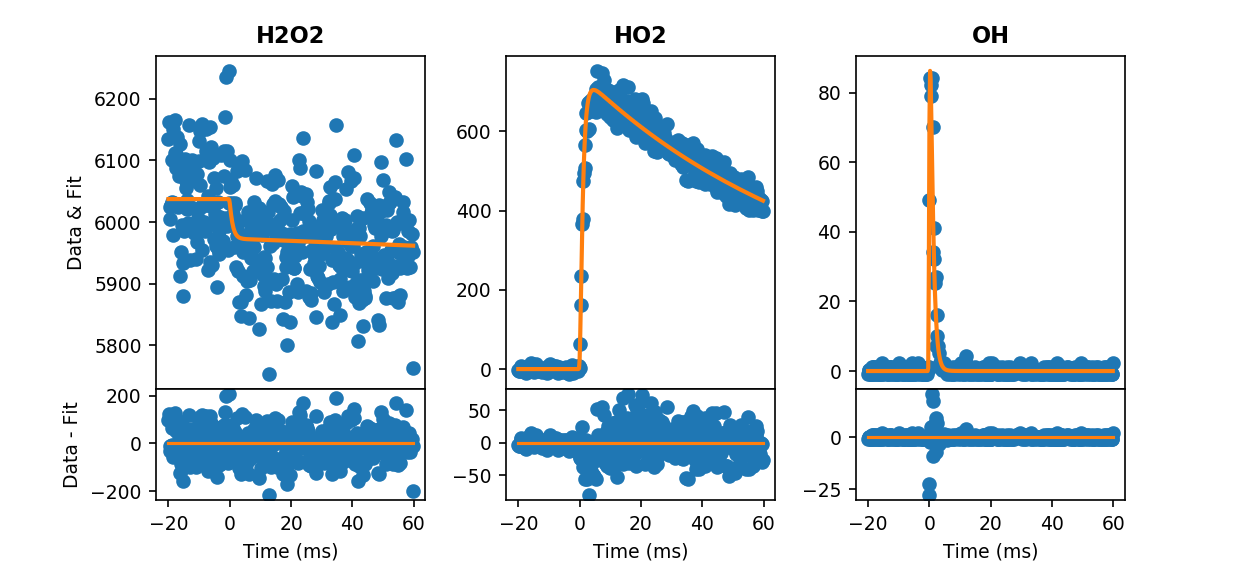

In [10]:
% matplotlib notebook

df_p, df_cov_p, df_corr_p, cost, mesg, ier \
    = model.fit(t, tbin, data, model_params, ALS_params, save_fn='ex_fit_model_scaled_1.csv')

In [13]:
import importlib
importlib.reload(ALS)
model = ALS.KineticModel(model_H2O2_depletion, err_weight=False)